In [1]:
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kipoi_cadd.data import CaddSparseDataset, cadd_sparse_train_valid_data_one, sparse_cadd_dataset
from kipoi_cadd.models import logistic_regression_keras
from scipy.stats import pearsonr
from scipy.sparse import load_npz
from sklearn.externals import joblib
%matplotlib inline

Using TensorFlow backend.


## 1. Compare models
### 1.a. Accuracy with CADD's model
Obtain predictions from CADD's as provided on [github](https://github.com/kircherlab/CADD-scripts/blob/master/data/models/GRCh37/CADD1.4-GRCh37.mod) of our sparse matrices generated with `kipoi-cadd/src/02_retrain_cadd_v1.4/generate_datasets.py`.

In [2]:
model_cadd_file = "/s/project/kipoi-cadd/data/models/CADD1.4-GRCh37.mod"
all_npz_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sparse_matrices/all.npz"
all_id_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/variant_ids/all.pkl"

In [3]:
model_cadd, scaler_cadd = joblib.load(model_cadd_file)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
import pandas as pd
di = pd.read_csv("/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/humanDerived_InDels.csv.gz", nrows=10)
di.shape

(10, 904)

In [5]:
_, scaler_cadd = joblib.load(model_cadd_file)
scaler_cadd.scale_.shape

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(904,)

In [8]:
"""
ds = CaddSparseDataset(all_npz_file, all_id_file, "v1.4")
X, y = ds.load_all()
"""
all_npz = load_npz(all_npz_file)
all_scaled = scaler_cadd.transform(all_npz)

KeyboardInterrupt: 

In [ ]:
X_scaled = all_scaled[:,1:]
y = all_scaled[:,0]
model_cadd.score(X_scaled, y)

### 1.b. Accuracy with our model
KipoiCADD's model. LogisticRegression trained with the following hyperparameters:
 - C = 1
 - solver = 'lbfgs'
 - tolerance = 0.0001
 - max_iter = 13
 - warm_start = True

In [ ]:
# Score our model and scale data with CADD's scaler
model_kipoicadd_file = "/tmp/gin-train/dc11c9b5d4114edab3a68d6ee05f963d/model.h5"
model_kipoicadd = joblib.load(model_kipoicadd_file)
model_kipoicadd.score(X_scaled, y)

In [ ]:
# Score our model and scale data with our scaler
scaler_kipoicadd_train_file = "/s/project/kipoi-cadd/data/models/KipoiCadd_new_train_GRCh37.scaler"
scaler_kipoicadd_train = joblib.load(scaler_kipoicadd_train_file)

ds = CaddSparseDataset(all_npz_file, all_id_file, "v1.4") # reload data just in case
X, y = ds.load_all()
X_scaled_kipoicadd = scaler_kipoicadd_train.transform(X)

model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
model_kipoicadd.score(X_scaled_kipoicadd, y)

### 1.c. Compare coefficients

In [ ]:
# Plot coefficients
model_cadd, scaler_cadd = joblib.load(model_cadd_file) # reload model and scaler just in case
plt.scatter(range(model_cadd.coef_.shape[1]), model_cadd.coef_[0], alpha=0.3);
plt.xlabel("Feature")
plt.ylabel("Feature coeficient")
plt.title("CADD model")
plt.show()

In [ ]:
# Plot coefficients
model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
plt.scatter(range(model_kipoicadd.coef_[0].shape[0]), model_kipoicadd.coef_[0], alpha=0.3);
plt.xlabel("Feature");
plt.ylabel("Feature coeficient");
plt.title("KipoiCADD model");

In [ ]:
# Plot coefficients
model_cadd, _ = joblib.load(model_cadd_file) # reload model just in case
model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
plt.scatter(model_cadd.coef_[0], model_kipoicadd.coef_[0], alpha=0.3);
plt.title("CADD's coef_ vs KipoiCADD's coef_");
plt.plot([-0.02, 0.04], [-0.02, 0.04], color='red');

corr = pearsonr(model_cadd.coef_[0], model_kipoicadd.coef_[0])
print("Correlation between coeficients: {:.2f}".format(corr[0]))

## 2. Compare scalers
### 2.a Generate our own scaler
_You may skip this part as the scalers have already been generated and saved. This is just to show how they were generated._

In [ ]:
"""
train_npz_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sparse_matrices/train.npz" # Shape (23244593, 905) first column is y
train_id_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/variant_ids/train.pkl"

ds = CaddSparseDataset(train_npz_file, train_id_file, "v1.4")
scaler_kipoicadd_train = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train, y_train = ds.load_all()
scaler_kipoicadd_train.fit(X_train)
joblib.dump(scaler_kipoicadd_train, scaler_kipoicadd_train_file)
"""

### 2.b. Compare means
Our scaler trained on the training set vs. scaler from CADD

In [ ]:
# CADD's scaler vs our scaler extracted from the train set
scaler_kipoicadd_train_file = "/s/project/kipoi-cadd/data/models/KipoiCadd_new_train_GRCh37.scaler"
scaler_kipoicadd_train = joblib.load(scaler_kipoicadd_train_file) # reload scaler just in case
_, scaler_cadd = joblib.load(model_cadd_file) # reload scaler just in case
plt.scatter(scaler_cadd.mean_, scaler_kipoicadd_train.mean_, alpha=0.3);
plt.title("CADD's mean_ vs KipoiCADD's mean_ (train set)");
plt.plot([0, 500], [0, 500], color='red');

corr = pearsonr(scaler_cadd.mean_, scaler_kipoicadd_train.mean_)
print("Correlation between means: {:.2f}".format(corr[0]))

Correlation between means: 0.93


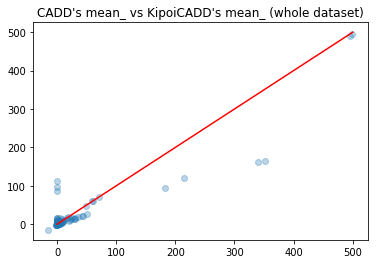

In [12]:
# CADD's scaler vs our scaler extracted from the whole dataset
scaler_kipoicadd_file = "/s/project/kipoi-cadd/data/models/KipoiCadd_all-GRCh37.scaler"
scaler_kipoicadd = joblib.load(scaler_kipoicadd_file) # reload scaler just in case
_, scaler_cadd = joblib.load(model_cadd_file) # reload scaler just in case
plt.scatter(scaler_cadd.mean_, scaler_kipoicadd.mean_, alpha=0.3);
plt.title("CADD's mean_ vs KipoiCADD's mean_ (whole dataset)");
plt.plot([0, 500], [0, 500], color='red');

corr = pearsonr(scaler_cadd.mean_, scaler_kipoicadd.mean_)
print("Correlation between means: {:.2f}".format(corr[0]))

Correlation between means: 0.88


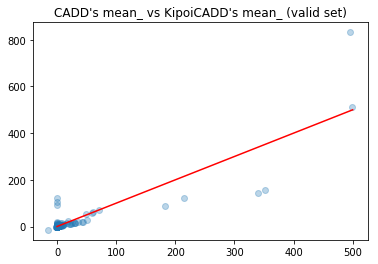

In [14]:
# CADD's scaler vs our scaler extracted from the valid set (this is a holdout set, this is not ClinVar data)
scaler_kipoicadd_valid_file = "/s/project/kipoi-cadd/data/models/KipoiCadd_valid-GRCh37.scaler"
scaler_kipoicadd_valid = joblib.load(scaler_kipoicadd_valid_file) # reload scaler just in case
_, scaler_cadd = joblib.load(model_cadd_file) # reload scaler just in case
plt.scatter(scaler_cadd.mean_, scaler_kipoicadd_valid.mean_, alpha=0.3);
plt.title("CADD's mean_ vs KipoiCADD's mean_ (valid set)");
plt.plot([0, 500], [0, 500], color='red');

corr = pearsonr(scaler_cadd.mean_, scaler_kipoicadd_valid.mean_)
print("Correlation between means: {:.2f}".format(corr[0]))

### 2.c. Compare variances
Our scaler trained on the training set vs. scaler from CADD

Correlation between variances: 0.94


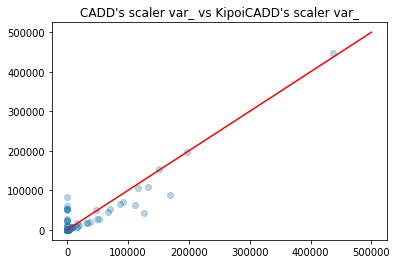

In [15]:
plt.scatter(scaler_cadd.var_, scaler_kipoicadd_train.var_, alpha=0.3);
plt.title("CADD's scaler var_ vs KipoiCADD's scaler var_");
plt.plot([0, 500000], [0, 500000], color='red');
corr = pearsonr(scaler_cadd.var_, scaler_kipoicadd_train.var_)
print("Correlation between variances: {:.2f}".format(corr[0]))